## Text Analysis
<hr>
<br>
Here i perform a simple text analysis on whatsapp text data.
<br>
The goal of this analysis is to study group activities.
<br>
Look at the most used words, emojis, most active times and most active users.
<br>
For the most used words, i split between the English and non English words.
<br>
The main aim of the analysis is to understand and determine chats in the group match the initial purpose of creating the group.

In [2]:
# importing the packages required
#!pip install emoji
import emoji
import re
import pandas as pd
from collections import Counter
import regex
import os
from wordcloud import WordCloud, STOPWORDS
import nltk
#nltk.download('words')
from nltk.corpus import words
#nltk.download('stopwords')
from nltk.corpus import stopwords
import enchant
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
allEnglishWords = enchant.Dict("en")
#print(type(allEnglishWords))
additionalWords = ["i'll", "i'm", "thats", "dont", "hehehe", "hehe"]
for word in additionalWords:
    allEnglishWords.add(word)

In [3]:
# Customized methods to be used in the project

# used to get all emojis in text
def getEmojiList(text):
    emojiList = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any (char in emoji.UNICODE_EMOJI['en'] for char in word):
            emojiList.append(word)
    return emojiList

# get the emojis in order of highest frequency
def getEmojisCount(text):  
    emojiList = getEmojiList(text) 
    c = Counter(emojiList) 
    return c
    
# returns the most used 5 emojis in the text supplied
def getTop5Emojis(text):
    result = getEmojisCount(text)
    topEmojis = result.most_common(5)
    topEmojis = [e[0] for e in topEmojis]
    topEmojis = ''.join(topEmojis)
    return topEmojis

# get english words count
def getEnglishWords(text):
    stops = list(set(stopwords.words('english')))
    stops = [stop.lower() for stop in stops]
    stops.extend(['like'])
    stops = tuple(sorted(stops))
    # converting to a lsit
    text = text.split(' ')
    # putting all words in lower case
    text = [word.strip().lower() for word in text]
    # removing stop words
    text = [word for word in text if word not in stops]
    # removing empty strings and non english words
    text = [word for word in text if len(word) > 1 and allEnglishWords.check(word)==True]
    return text

# get non english words
def getNonEnglishWords(text):
    # converting to a lsit
    text = text.split(' ')
    # putting all words in lower case
    text = [word.strip().lower() for word in text]
    text = [re.sub("[^a-zA-Z,.'\"()]",'',word) for word in text]
    # removing empty strings and non english words
    text = [word for word in text if len(word) > 1 and allEnglishWords.check(word)==False]
    return text
     
# get most 4 used words
def getTopFourWords(text):
    counter = Counter(text)  
    top = counter.most_common(4)
    top = [w[0] for w in top]
    top = " | ".join(top)
    return top

In [4]:
# initializing the path to the file
# reading the file
# picking out the date pattern, given data is stored in date : activity format
# getting the system notifications
# getting the messagesand their senders
# adding all these to a dataframe

path = os.getcwd()
#file = f"{path}/_chat_DSATA2022.txt"
#file = f"{path}/_chat.txt"
file = f"_chat.txt"
#file = f"{path}/_chatTartans2023.txt"

scoreFile = open(file, encoding="utf8")
lines = scoreFile.read()
lines = lines.replace('\n', ' ')
lines = ' '.join(lines.split('\n'))

# getting the date pattern
pattern = '\[\d{2}/\d{2}/\d{4},\s\d{2}:\d{2}:\d{2}\]'
# getting the activities
activity = re.split(pattern, lines)[1:]
#activity = [message.strip() for message in activity]
# cleaning up the activites
# confirming if the activity is a user initiated message
user_messages = [1 if ':' in message else 0 for message in activity]
# confirming if the activity is a system generated notification 
notifications = [1 if val == 0 else 0 for val in user_messages]
# getting the senders of the messages
senders = [message[:message.find(':')].strip() if ':' in message else "SystemNotification" for message in activity]
# removing senders' names from activity
activity = [message[message.find(':')+1:] if ':' in message else message for message in activity]
activity = [a.strip() for a in activity]
# getting length of the messages
messageLength = [len(message) for message in activity]
# getting the dates for all the activity
# the format is [21/12/2021, 07:53:21]
message_dates = re.findall(pattern,lines)
# removing all [] 
message_dates = [date.replace('[','').replace(']','') for date in message_dates]
# confirming that activity and dates have same length
print(len(activity), len(message_dates))
data = pd.DataFrame({"dates":message_dates, "Activity":activity, "Sender":senders,
                     "Message":user_messages, "Length":messageLength})
groupName = senders[0]
data.head()

9926 9926


,dates,Activity,Sender,Message,Length
0,"16/10/2013, 06:47:49",‎Messages and calls are end-to-end encrypted. ...,FAMILY 👨‍👩‍👧‍👦,1,121
1,"16/10/2013, 06:47:49",‎Kabum created this group,SystemNotification,0,25
2,"16/10/2013, 06:47:49",‎You were added,SystemNotification,0,15
3,"03/04/2018, 18:57:59",Hi people,Tiano,1,9
4,"03/04/2018, 19:04:15",👋,Richard,1,1


In [6]:
# Performing data cleaning
# removing notifications
# transforming date column
# getting number of ommited data belonging to files
# looking at average stats like messages per day, per hour

notificationLength = len(data[data["Sender"] == "SystemNotification"])
print(f"Group name is {groupName}.")
print(f"There are {notificationLength} notifications")

if groupName in data.Sender.unique():
    cleanedData = data.drop(0)
    cleanedData = cleanedData[cleanedData["Sender"] != "SystemNotification"]

files = list(cleanedData["Activity"])
files = [val for val in files if val.replace("\u200e", '').strip().endswith("omitted")]
print(f"There are {len(files)} omitted files. These include images, videos, documents, gifs.")
cleanedData = cleanedData[~cleanedData['Activity'].isin(files)]
# changing the dates column to date time
cleanedData['dates'] = pd.to_datetime(cleanedData['dates'], format='%d/%m/%Y, %H:%M:%S')
daysCount = len(cleanedData['dates'].dt.date.unique())
totalLen = len(cleanedData)
dailyAverage = round(float(totalLen/daysCount),3)
hourlyAverage = round(float(dailyAverage/24),4)
print(f"There are a total of {totalLen} messages left.")
print(f"There are averagely {dailyAverage} messages per day.")
print(f"There are averagely {hourlyAverage} messages per hour.")
cleanedData.head()

Group name is FAMILY  👨‍👩‍👧‍👦.
There are 6 notifications
There are 1604 omitted files. These include images, videos, documents, gifs.
There are a total of 8315 messages left.
There are averagely 18.727 messages per day.
There are averagely 0.7803 messages per hour.


,dates,Activity,Sender,Message,Length
3,2018-04-03 18:57:59,Hi people,Tiano,1,9
4,2018-04-03 19:04:15,👋,Richard,1,1
8,2020-01-11 14:35:32,Nakibule told somene that Angelo is pastor in...,Tiano,1,57
9,2020-01-11 14:36:06,can you imagine Angelo nga abulila enjili 😁😁,Tiano,1,44
10,2020-01-11 14:37:19,"anyway back to the point, the lady called me a...",Tiano,1,138


In [7]:
# Most active users based on messgaes
# includes 5 most used emojis
# most 4 used english words
# also top 4 non english words
mostActivity = pd.DataFrame(cleanedData["Sender"].value_counts()).reset_index()
mostActivity.columns = ['sender','Messages']
totalLength = []
topEmojis = []
topEnglishWords = []
topNonEnglishWords = []
senders = cleanedData.Sender.unique()
for s in mostActivity['sender']:
    dt = cleanedData[cleanedData["Sender"]==s]
    length = dt["Length"]
    messages = list(dt['Activity'])
    messages = ' '.join(messages)
    emojis = getTop5Emojis(messages)
    topEmojis.append(emojis)
    totalLength.append(sum(length))
    topEnglishWords.append(getTopFourWords(getEnglishWords(messages)))
    topNonEnglishWords.append(getTopFourWords(getNonEnglishWords(messages)))
    
mostActivity["characters"] = totalLength
mostActivity["chars per text"] = mostActivity["characters"]/mostActivity["Messages"]
mostActivity["Top 5 Emojis"] = topEmojis
mostActivity["Top 4 English Words"] = topEnglishWords
mostActivity["Top 4 Non English Words"] = topNonEnglishWords
mostActivity.head(10)

,sender,Messages,characters,chars per text,Top 5 Emojis,Top 4 English Words,Top 4 Non English Words
0,Richard,2882,119266,41.383067,😂😁🤣😄🙏,it’s | one | don’t | know,lol | ur | jingo | heheh
1,Tiano,1257,36871,29.332538,😂😅🤣😀😊,hehe | good | okay | know,nga | naye | angelo | messi
2,Kabum,1254,50007,39.877990,😂🙏🏽👏🏽😃👍🏽,hehehe | call | good | one,ugx | im | youre | abt
3,Angelo(us),1158,32527,28.088946,😃👍🏼😂🤔👏🏼,good | one | call | think,yah | ok | nga | angelo(us)
4,kaksmat US,951,38080,40.042061,😀😂👍✌️😭,ya | see | people | one,"lol | ya, | kaale | nga"
5,Champ Matt US,813,29394,36.154982,😀👍😁😃😂,ya | good | no. | man,lol | pc | nga | ug


In [459]:
# overall
# most used emojis
# most used English words
# most used non English words
messages = list(cleanedData['Activity'])
messages = [message.strip() for message in messages]
messages = [message.lower() for message in messages]
allmessages = ' '.join(messages)
print(f"Top Emojis are ::  {getTop5Emojis(allmessages)}")
print(f"Top English words are ::  {getTopFourWords(getEnglishWords(allmessages))}")
print(f"Top nonEnglish words are ::  {getTopFourWords(getNonEnglishWords(allmessages))}")

Top Emojis are ::  😂😃😀🤣😅
Top English words are ::  one | good | man | think
Top nonEnglish words are ::  lol | nga | jingo | ok


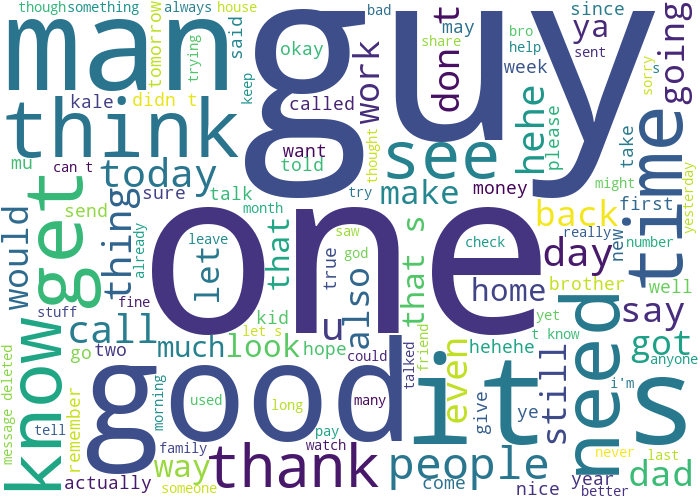

In [460]:
# visualizing a word cloud
# inlcuding stop words
# English Words cloud
engWords = getEnglishWords(allmessages)
engWords = ' '.join(engWords)
wordcloud = WordCloud(width = 700, height = 500, 
                background_color ='white', 
                stopwords = [], 
                min_font_size = 10).generate(engWords)
wordcloud.to_image()

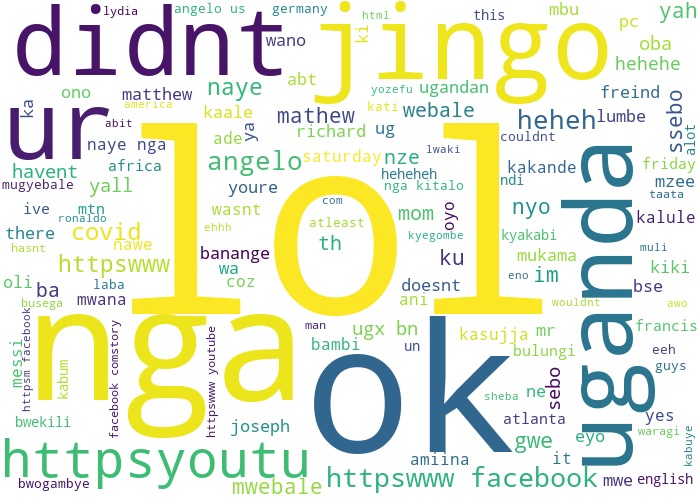

In [461]:
# Non English Words cloud
nonEngWords = getNonEnglishWords(allmessages)
nonEngWords = ' '.join(nonEngWords)
wordcloud = WordCloud(width = 700, height = 500, 
                background_color ='white', 
                stopwords = [], 
                min_font_size = 10).generate(nonEngWords)
wordcloud.to_image()

In [462]:
# looking at the data column structure
cleanedData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8315 entries, 3 to 9925
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dates     8315 non-null   datetime64[ns]
 1   Activity  8315 non-null   object        
 2   Sender    8315 non-null   object        
 3   Message   8315 non-null   int64         
 4   Length    8315 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 389.8+ KB


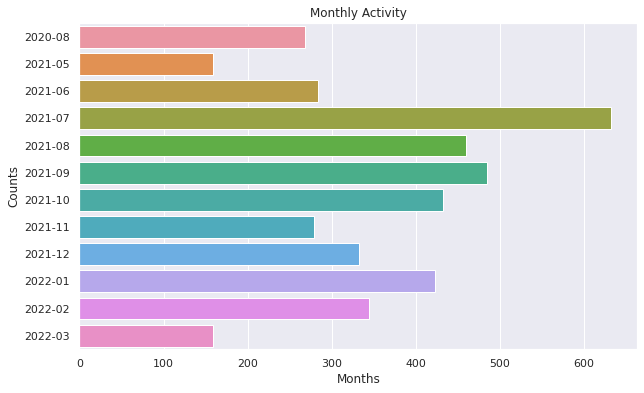

In [463]:
# visualizing monthly activity based
# on number of messages per month
months = (cleanedData['dates'].dt.to_period('M').unique())
months = list(months.astype(str))
monthsLen = len(months)
if monthsLen > 12:
    months = months[monthsLen-12:]

counts = []
for month in months:
    counts.append(len(cleanedData[cleanedData['dates'].dt.to_period('M') == month]))
fig,ax = plt.subplots(figsize = (10, 6))
sns.barplot( y=months, x=counts)
plt.title("Monthly Activity")
plt.xlabel("Months")
plt.ylabel("Counts")
plt.show()

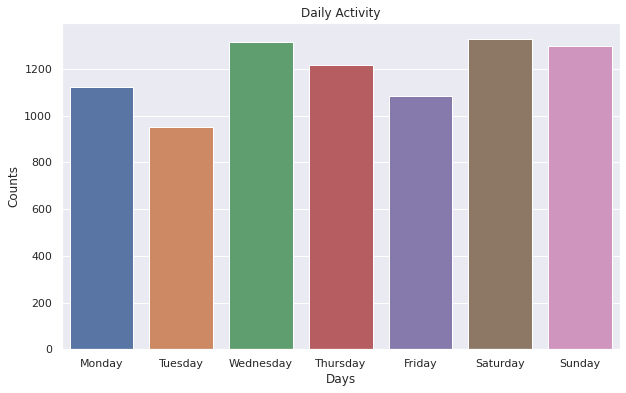

In [464]:
# visualizing daily activity based
# on number of messages per day
dayNames = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
counts = []
for day in dayNames:
    counts.append(len(cleanedData[cleanedData['dates'].dt.day_name() == day]))
fig,ax = plt.subplots(figsize = (10, 6))
sns.barplot( x=dayNames, y=counts)
plt.title("Daily Activity")
plt.xlabel("Days")
plt.ylabel("Counts")
plt.show()

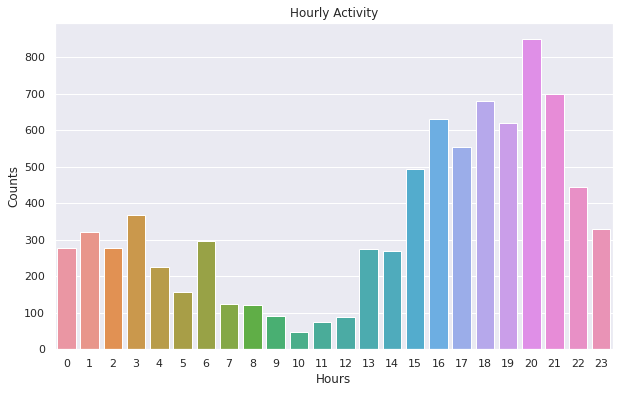

In [465]:
# visualizing hourly activity based
# on number of messages per hour
#hours = sorted(list(cleanedData['dates'].dt.hour.unique()))
hours = list(range(24))
counts = []
for hour in hours:
    counts.append(len(cleanedData[cleanedData['dates'].dt.hour == hour]))
fig,ax = plt.subplots(figsize = (10, 6))
sns.barplot( x=hours, y=counts)
plt.title("Hourly Activity")
plt.xlabel("Hours")
plt.ylabel("Counts")
plt.show()

In [466]:
sys = list(data[data["Sender"] == "SystemNotification"]["Activity"])
sys = [val.replace("\u200e",'').replace("\u202a",'').replace("\u202c",'').replace("\xa0",'') for val in sys]
sys

['Kabum created this group',
 'You were added',
 'Kabum was added',
 '+256700958238 left',
 '+4915218024859 left',
 'kaksmat US changed their phone number to a new number. Tap to message or add the new number.']